<img src="https://static.dribbble.com/users/410907/screenshots/4531744/price_formation.gif"/>

# Определение цены товара
***
### Можем ли мы автоматически предлагать цену для нового товара или изменять её для пользователей?

От чего только не зависит цена на товар: сезонность, бренд, доступность на рынке и все-все-все другое, что не только входит в конкретный товар, а даже его "окружает".

Давайте погрузимся в мир ретейла и продаж, представим себе, что мы аналитики, которым поставили задачу построить такую модель, которая будет определять цену любого товара, который поступить. Но чтобы протестить вашу разработку, Ваша компания договорилась с платформой-"онлайн-барахолкой" для тестирования вашей модели. 

Платформа предложила свои исторические данные по тому, какую цену ставили пользователи, а также ваша компания "замешала" туда свои данные. У вас на руках данные, которые содержат: описание продукта, категории продукта, бренд и дополнительные детали. К несчастью (а может и нет), вы не знаете, где и какие данные.

Ваша задача состоит из двух основных шагов:
* **Сделать анализ данных**
* **Построить модель автоматического определения цены**

### Набор данных состоит из

- **ID**: id предмета
- **Name:** строка - наименование товара
- **Item Condition:** внутреннее условие (назначается поставщиком товара)
- **Category Name:** категория предмета
- **Brand Name:** бренд (если имеется)
- **Shipping:** доступна или нет доставка товара от поставщика
- **Item Description:** полное описание товара
- **Price:** фактическая цена за которую был продан товар (так как товар может торговаться по одной цене, а потом иметь скидки, тут указана цена именно продажи). В USD. Используем, как целевую переменную.

### Основные способы обработки данных в тексте
- **Удаление стоп слов:** удаление слов, которые много в тексте, но они не несут смысловой нагрузки

- **Bag of Words: ** поиск среди слов основных носителей информации и преобразование их признаки 

- **TFIDF**: статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

- **N-grams**: последовательность слов, которые можно воспринимать, как термин или категорию

- **Лемматизация описания**: процесс приведения словоформы к лемме — её нормальной (словарной) форме

- **Topic Models**: Тип обработки данные, которые ищет значимые последовательности


# Ключевые точки, через которые пройдем
***

**Определение бизнес потребности данной работы** 

**Как обработать данные и приготовить их к работе с алгоритмом**

**Как обработать текст в описании товара** 

**Как решить проблему автоматической определения цены**

**Как измерить результат**

**Как использовать данное решение** 



# Чем Вы заполните пустой ценник?

<img src = "img/BestPriceRed.jpg"/>

# Import Packages
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pandas_profiling as ppf

In [2]:
from string import punctuation

In [3]:
# vstack - добавляет строчки
# hstack - добавляет колонки 
# csr_matrix - используем для работы с матрицей
from scipy.sparse import vstack, hstack, csr_matrix

In [4]:
# CountVectorizer - используется для расчтета частоты слов
# TfidfVectorizer - используется для расчета TFIDF, функция, которая считает важность слов в предложении
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

<img src="img/tfidf.png"/>

In [5]:
# LabelBinarizer - конвертация буквенных значений (категорий) в цифровые значения "A,B,C" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer

In [6]:
# Ridge - используем для уменьшения мультиколлиальности в регрессии (L2 Regularization)
from sklearn.linear_model import Ridge

<img src="img/ridgeReg.png"/>

# Import Train / Test Data
***

In [7]:
# Загружаем данные
train = pd.read_csv('data/train/train.tsv', sep = '\t', nrows = 1000)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [19]:
import pandas_profiling as ppf

ppf.ProfileReport(train)



In [8]:
# загружаем данные теста
test = pd.read_csv('data/test/test.tsv', sep = '\t',engine = 'python', nrows=100)
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [8]:
# какую мы видим проблему?!
train['price']

0      10.0
1      52.0
2      10.0
3      35.0
4      44.0
       ... 
995    13.0
996    17.0
997     7.0
998     3.0
999    12.0
Name: price, Length: 1000, dtype: float64

In [9]:
# объяснения про цену и её обработку

In [10]:
# одно из решений (Transformation), а какие ещё ?
y = np.log1p(train['price'])
y

0      2.397895
1      3.970292
2      2.397895
3      3.583519
4      3.806662
         ...   
995    2.639057
996    2.890372
997    2.079442
998    1.386294
999    2.564949
Name: price, Length: 1000, dtype: float64

# Соединение выборок Test / Train
***

In [23]:
# соединим два набор в один
combined = pd.concat([train,test])

# почему этот метод? Какие ещё есть?
#combined.head()

# сохраним только тест
#tst = test[['test_id']]

# получим кол-во строк в train
train_size = train.shape[0] #len(train)
train_size

1482535

In [24]:
combined.shape

(1482635, 9)

In [11]:
# отбор сэмпла
#combined
combined_ML = train.sample(frac=0.1).reset_index(drop=True)

In [12]:
combined_ML.shape

(100, 8)

# Как начать анализ

### Или как научиться есть пирог

<img src="img/piechartdr.jpg"/>

# Обработка текста (самый большой кусок)
***

a. удаляем пунктуацию

b. удаляем цифры

c. ищем и удаляем "стоп-слова"

d. приводим все слов к единому значению

e. приводим к "нормальной словарной форме" (Лемматизация) / оставляем только общую часть от слова и его форм (стемминг)

##  удаляем пунктуацию

In [13]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
# создаем список для замены 
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

**замена пунктуации**

In [15]:
import string
def remove_punctuation(sentence):  #str -> str
    return sentence.translate(str.maketrans('', '', string.punctuation))

###  удаление чисел

In [16]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()]) #обсуждение: надо делать? Почему? Какие ещё варианты?
    return x

### удаление стоп слов

In [ ]:
# есть библиотека - помощник
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

#### переводим в нижний регистр

In [17]:
def to_lower(x):
    return x.lower()

# Исследуем данные
***

**Пропущенные значения в столбцах:**
- Category_name
- Brand_name
- Item_description

**Категориальные переменные (сделаем их кодировку):** 
- name
- category_name
- brand_name
- item_description


+++ обсуждение способов кодировки и их представление (возможно совместное составление новых методо). Дискуссия на темы: LabelEncoding, OHE, Target Encoding, Cross - Fold, Leave - One - Out.

+++ Есть ли специальная реализация алгоритма МЛ для работы с категориями?

**Проверка на пропуски**

In [20]:
train.count()

train_id             593376
name                 593376
item_condition_id    593376
category_name        590835
brand_name           340359
price                593376
shipping             593376
item_description     593375
dtype: int64

**Типы данных**

In [21]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## Смотрим распределение цены на исторических данных
***

**Почему цена изменяется?**
- Количество поставки
- Бренд
- Фабричное / ручное изготовление
- "Качественный" товар
- Условия взаимодействия с товаром


**Обзор данных:**
- Средняя стоимость товара **26 USD**
- Медиана **17 USD**
- Максимальная цена товара **2000 USD**



++ Мы видем, что наши данные смещены (медиана и стреднее не одно и тоже значение), что это значит? Как это использовать?

<img src='img/skew.ppm'>

In [35]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [18]:
# Сделаем разбивку цены товара на квантили и посмотрим распределение на каждом из них

bins = [0, 10, 17, 29, 2001]
labels = ['q1','q2','q3','q4']
train['price_bin'] = pd.cut(train['price'], bins=bins, labels=labels)
train.groupby('price_bin')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_bin,,,,,,,,
q1,271.0,7.852399,2.065677,3.0,7.0,8.0,10.0,10.0
q2,257.0,13.762646,1.856704,11.0,12.0,14.0,15.0,17.0
q3,225.0,22.537778,3.316577,18.0,20.0,22.0,25.0,29.0
q4,247.0,69.425101,78.204089,30.0,36.0,45.0,66.0,650.0


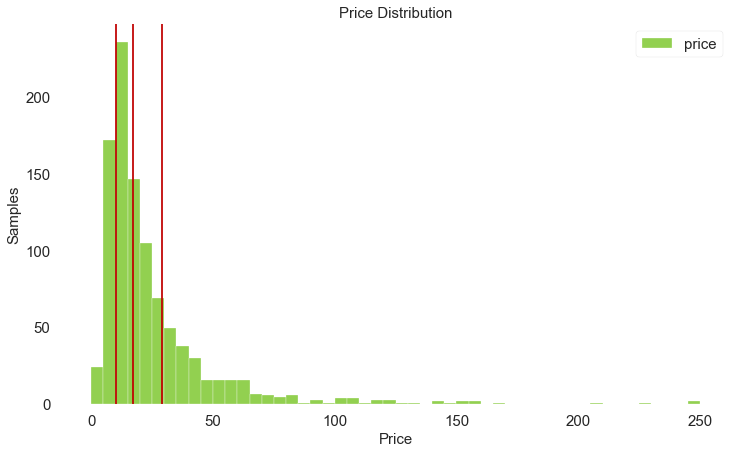

In [19]:
# визуализируем данные (какой лучший способ?)
plt.figure(figsize=(12, 7))
plt.hist(train['price'], bins=50, range=[0,250], label='price', color = '#92d050')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.axvline(10, color='#c00000')
plt.axvline(17, color='#c00000')
plt.axvline(29, color='#c00000')
plt.show()

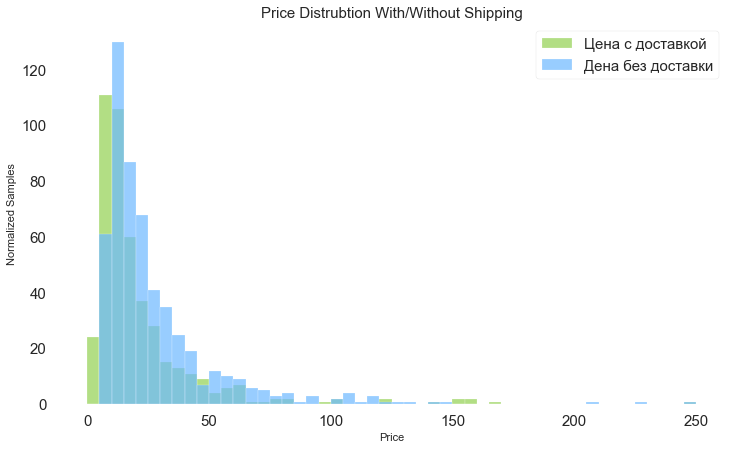

In [20]:
# сделаем разбивку по параметру (например доставка) и посмотрим распределение
# какой ещё параметр можно использовать?

shipping = train[train['shipping']==1]['price']
no_shipping = train[train['shipping']==0]['price']

plt.figure(figsize=(12,7))
plt.hist(shipping, bins=50, range=[0,250], alpha=0.7, label='Цена с доставкой', color = '#92d050')
plt.hist(no_shipping, bins=50, range=[0,250], alpha=0.7, label='Дена без доставки', color='#6db9ff')
plt.title('Price Distrubtion With/Without Shipping', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Normalized Samples')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Анализ бренда товара
***

In [26]:
# Получим уникальные бренды
train['brand_name'].nunique()

3751

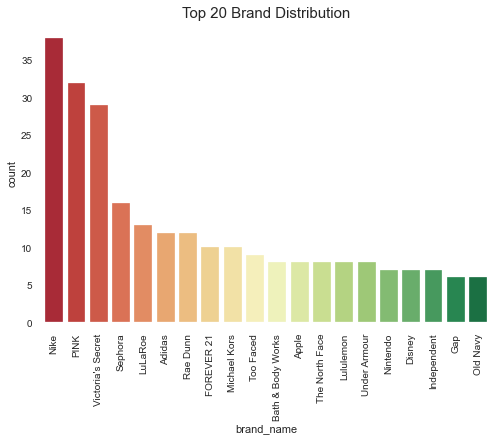

In [21]:
# Top 20
b20 = train['brand_name'].value_counts()[0:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20, palette = 'RdYlGn')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

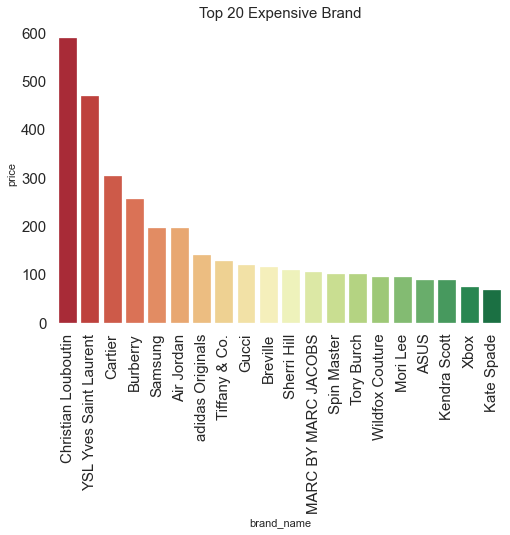

Nike                   0.065292
PINK                   0.054983
Victoria's Secret      0.049828
Sephora                0.027491
LuLaRoe                0.022337
                         ...   
Hollister Co.          0.001718
Missguided             0.001718
Majestic               0.001718
JBL                    0.001718
Nostalgia Electrics    0.001718
Name: brand_name, Length: 229, dtype: float64

In [22]:
# Сделаем обзор топ 20 и их стредюю цену
top20_brand = train.groupby('brand_name', axis=0).mean()
df_expPrice = pd.DataFrame(top20_brand.sort_values('price', ascending = False)['price'][0:20].reset_index())


ax = sns.barplot(x="brand_name", y="price", data=df_expPrice, palette='RdYlGn')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top 20 Expensive Brand', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
train['brand_name'].value_counts(1)

# Обзор категорий товара
***

In [23]:
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['category_main','category_sub1','category_sub2', 'price']]

cat_train.head()

,category_main,category_sub1,category_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0


## Основные категории

**Обзор интересов пользователей:**
- Товары относящиеся к категории Beauty в основном распределены для потребителей женщин (больше 56%)

++ Что её можно посмотреть?

**Генерация признаков товара на основе категорий и потреблений:**

* Можем мы определить потребителя товара и разбить категорию на принадлежность к полу? (мужской, женский, универсальный товар)

* Будет ли это значимо для определения цены?

* Можем ли создать признак по возрасту и разбить его на категории?

In [24]:
# Обзор основных категорий (что можно сказать по категории - электроника?)
train.groupby('category_main')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category_main,,,,,,,,
Beauty,155.0,17.006452,15.638986,3.0,9.00,14.0,20.00,150.0
Electronics,60.0,35.066667,60.087187,4.0,8.75,14.0,32.25,386.0
Handmade,14.0,33.785714,28.863548,3.0,11.25,21.0,51.00,90.0
Home,52.0,22.826923,19.143136,4.0,11.00,18.5,26.75,115.0
Kids,121.0,18.487603,18.315802,4.0,9.00,12.0,21.00,150.0
Men,69.0,35.405797,46.430314,6.0,12.00,23.0,40.00,271.0
Other,36.0,38.972222,106.427034,3.0,10.00,12.0,26.50,650.0
Sports & Outdoors,20.0,23.950000,15.994983,6.0,12.25,15.5,39.25,60.0
Vintage & Collectibles,31.0,36.709677,83.892071,3.0,7.00,18.0,29.50,470.0


In [56]:
# Посмотрим распределение
train['category_main'].value_counts(1)

Women                     0.451404
Beauty                    0.141205
Kids                      0.116651
Electronics               0.081281
Men                       0.063434
Home                      0.046114
Vintage & Collectibles    0.031614
Other                     0.030813
Handmade                  0.020954
Sports & Outdoors         0.016531
Name: category_main, dtype: float64

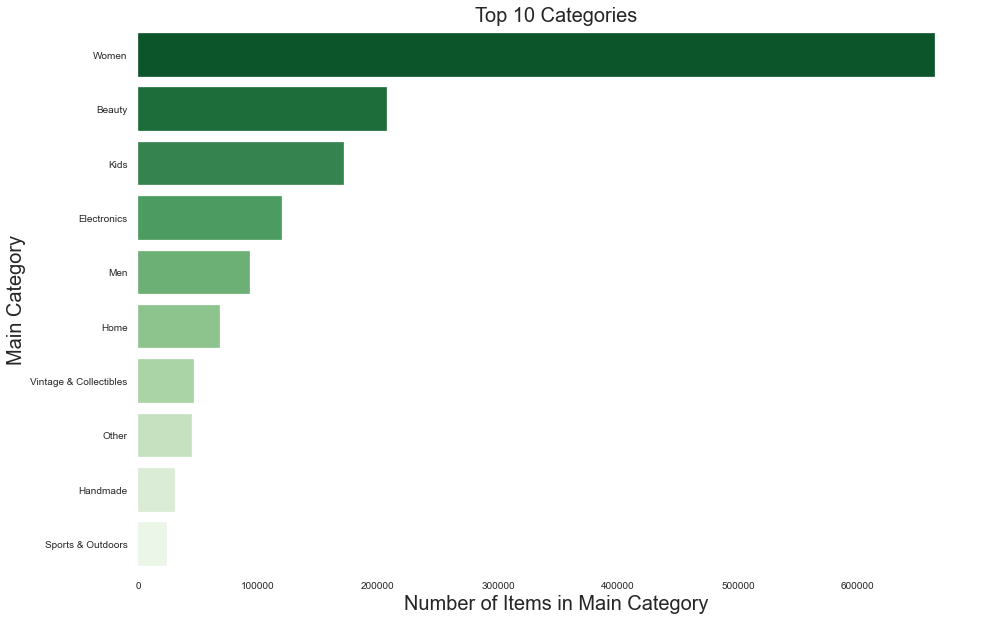

In [61]:
plt.figure(figsize=(15,10))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v', palette='Greens_r')
plt.title('Top 10 Categories', fontsize = 20)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items in Main Category', fontsize = 20)
plt.show()

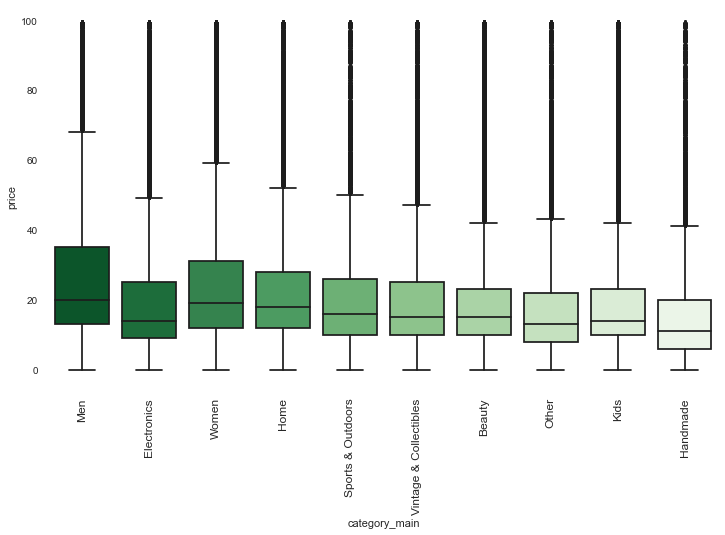

In [68]:
# какие есть способы визуализации, которые покажут:
# - где лежит основное кол-во данных?
# - как они распределены?
# - позволит уловить выбросы?
#main = pd.DataFrame(cat_train['category_main'].value_counts()).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
fig, axes = plt.subplots(figsize=(12, 7))
main = cat_train[cat_train["price"]<100]
# Use a color palette
ax = sns.boxplot( x=main["category_main"], y=main["price"], palette="Greens_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

plt.show()

In [69]:
# Выделим товары не имющщие бренда
train['no_brand'] = train['brand_name'].isnull()

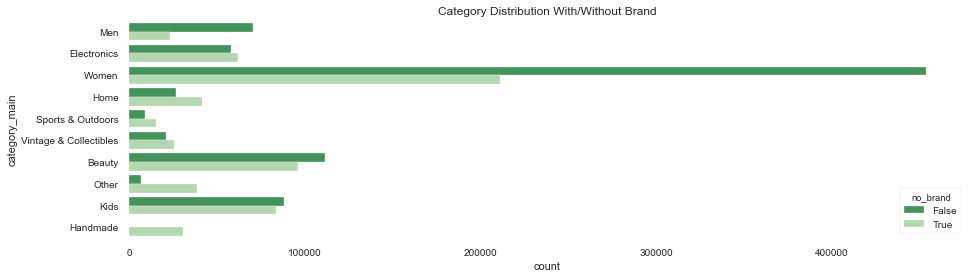

In [71]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='category_main', hue='no_brand', data=train, palette='Greens_r').set_title('Category Distribution With/Without Brand');
plt.show()

## Распределение по подкатегориям 2


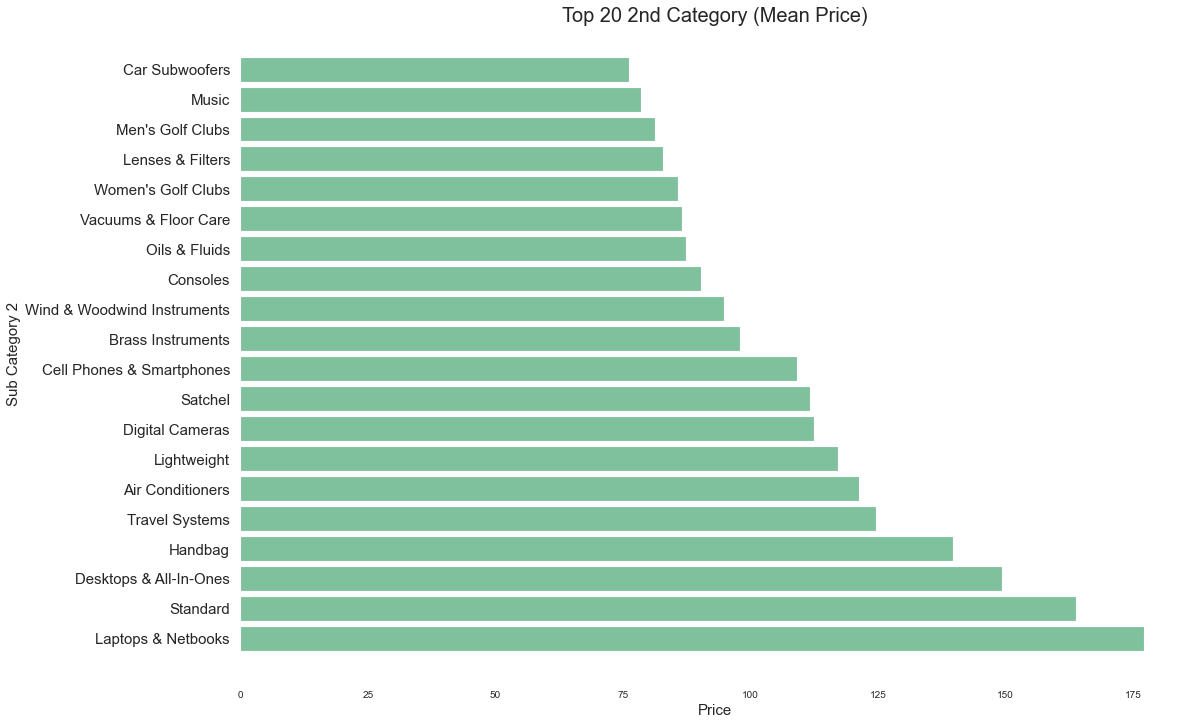

In [74]:
df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False).head(20)

plt.figure(figsize=(17, 12))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='#00823c')
plt.yticks(range(0,len(df)), df['category_sub2'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 2', fontsize=15)
plt.title('Top 20 2nd Category (Mean Price)', fontsize=20)
plt.show()

## Распределение по подкатегориям 1

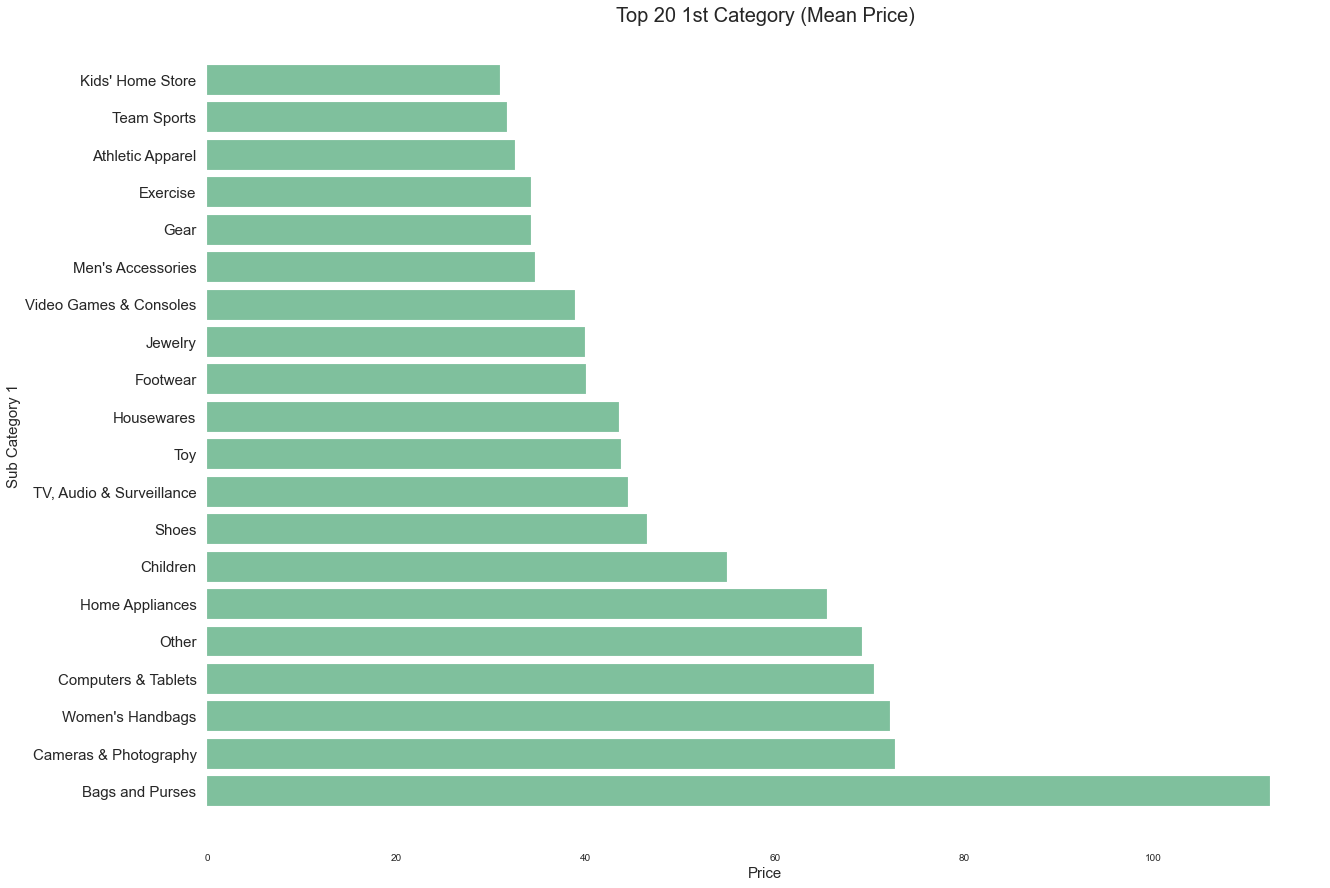

In [26]:
df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})
df= df.sort_values('mean', ascending=False)[0:20]

plt.figure(figsize=(20, 15))
plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='#00823c')
plt.yticks(range(0,len(df)), df['category_sub1'], fontsize=15)

plt.xlabel('Price', fontsize=15)
plt.ylabel('Sub Category 1', fontsize=15)
plt.title('Top 20 1st Category (Mean Price)', fontsize=20)
plt.show()

## Анализ описания товара

**Гипотезы:** 
- Влияет ли качественное описние и его длина на цену товара?
- Точность описания влияет на цену товара?

++ Какие ещё можно выбрать гипотезы?

In [30]:
# Удаление пунктуации в описании
# combined
combined_ML.item_description = combined_ML.item_description.astype(str)

descr = combined_ML[['item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))

descr['item_description'] = descr['item_description'].apply(remove_digits)
descr['item_description'] = descr['item_description'].apply(remove_punctuation)
#descr['item_description'] = descr['item_description'].apply(remove_stop_words)
descr.head(10)

D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,item_description,price,count
0,Kylie Happy Birthday Matte Mini Lipstick Kylie...,20.0,317
1,Brandy Bundle,24.0,13
2,SP Authentic Derek Jeter,3.0,34
3,Black with unique colors around the sides,16.0,42
4,Bundle for Kesha Sperry Top Slider Shoes Women...,31.0,255
5,No description yet,15.0,18
6,Sample sized never used Multifirming rejuvenat...,10.0,84
7,worn once red with black micro stripe,19.0,38
8,pack bundle sheets Fat Book,12.0,35
9,Jesus Sandals Size in Womens Like new only wo...,14.0,64


In [31]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

descr['item_description'] = descr['item_description'].apply(porter.stem)

D:\installprogramm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
descr.tail(10)

,item_description,price,count
90,red stripes print fidget hand finger spinner p...,8.0,92
91,adidas mensboys baseball cleats spikes shoes...,40.0,175
92,prices are firm unless you bundle all offers w...,10.0,383
93,distressed high waisted shorts from ae size,22.0,46
94,cute boutique brand suit floral print polyest...,41.0,93
95,real sterling silver stamped real crystal st...,24.0,178
96,look like kendra scott paid rm,6.0,32
97,brand new with seal oz solid makeup brush cle...,12.0,94
98,new authentic true religion outfit price is firm,34.0,49
99,iron man figure great shape has been neatly d...,25.0,96


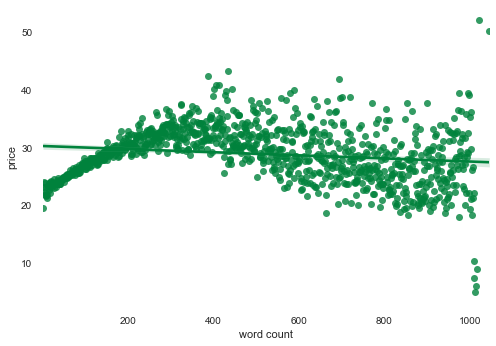

In [79]:
# сделаем визуализацию данных
# и посмотрим, как кол-во слов влияет на цену товара
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]), color = '#00823c')
plt.xlabel("word count")
plt.show()

# Препроцессинг обработки данных
***

In [33]:
combined_ML.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,40,Kylie Birthday Edition,1,Beauty/Makeup/Makeup Sets,Kylie Cosmetics,20.0,1,Kylie Happy Birthday Matte Mini Lipstick Kylie...
1,451,Brandy Bundle!!,2,Women/Tops & Blouses/T-Shirts,Brandy Melville,24.0,0,Brandy Bundle
2,240,1998 SP Authentic Derek Jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,1998 SP Authentic Derek Jeter #145
3,462,Women's Size S Nike DriFit Shorts,3,Women/Athletic Apparel/Shorts,Nike,16.0,0,Black with unique colors around the sides.
4,114,HOLD Kesha - Sperry Shoes UA Pants,3,Women/Shoes/Loafers & Slip-Ons,NaN,31.0,0,Bundle for Kesha: Sperry Top Slider Shoes Wome...


In [34]:
# обработка пропусков
def handle_missing_values(df):
    df['category_name'].fillna(value='missing', inplace=True)
    df['brand_name'].fillna(value='None', inplace=True)
    df['item_description'].fillna(value='None', inplace=True)

In [35]:
# преобразование в категориальные данные
# - какое значение это имеет? На что может повлиять? Как отразиться на наборе данных?
def to_categorical(df):
    df['brand_name'] = df['brand_name'].astype('category')
    df['category_name'] = df['category_name'].astype('category')
    df['item_condition_id'] = df['item_condition_id'].astype('category')

In [ ]:
# какие ещё можно сделать категориальные преобразования?
# подходит ли предложенный способ для кодировки?

<img src='img/categorical.png'>

# Применение к данным
***

In [45]:
# применяем функции к набору
handle_missing_values(combined)
to_categorical(combined)

In [36]:
# 
handle_missing_values(combined_ML)
to_categorical(combined_ML)

In [39]:
# удаляем пунктуации
combined_ML.item_description = combined_ML.item_description.astype(str)

combined_ML['item_description'] = combined_ML['item_description'].apply(remove_digits)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_punctuation)
#combined_ML['item_description'] = combined_ML['item_description'].apply(remove_stop_words)
combined_ML['item_description'] = combined_ML['item_description'].apply(to_lower)

combined_ML['name'] = combined_ML['name'].apply(remove_digits)
combined_ML['name'] = combined_ML['name'].apply(remove_punctuation)
#combined_ML['name'] = combined_ML['name'].apply(remove_stop_words)
combined_ML['name'] = combined_ML['name'].apply(to_lower)

combined_ML.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,40,kylie birthday edition,1,Beauty/Makeup/Makeup Sets,Kylie Cosmetics,20.0,1,kylie happy birthday matte mini lipstick kylie...
1,451,brandy bundle,2,Women/Tops & Blouses/T-Shirts,Brandy Melville,24.0,0,brandy bundle
2,240,sp authentic derek jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,sp authentic derek jeter


In [48]:
# 
combined.item_description = combined.item_description.astype(str)

combined['item_description'] = combined['item_description'].apply(remove_digits)
combined['item_description'] = combined['item_description'].apply(remove_punctuation)
combined['item_description'] = combined['item_description'].apply(remove_stop_words)
combined['item_description'] = combined['item_description'].apply(to_lower)

combined['name'] = combined['name'].apply(remove_digits)
combined['name'] = combined['name'].apply(remove_punctuation)
combined['name'] = combined['name'].apply(remove_stop_words)
combined['name'] = combined['name'].apply(to_lower)

# Генерация новых сущностей (фичей) на основе категорий (Main, Sub1, Sub2)
***

In [42]:
combined_ML.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
dtype: bool

In [50]:
combined.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,None,Men/Tops/T-shirts,3,description yet,mlb cincinnati reds shirt size xl,10.0,1,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,1,adorable top hint lace key hole back pale pink...,avaviv blouse,10.0,1,NaN,2.0
3,None,Home/Home Décor/Home Décor Accents,1,new tags leather horses retail rm stand foot h...,leather horse statues,35.0,1,NaN,3.0
4,None,Women/Jewelry/Necklaces,1,complete certificate authenticity,k gold plated rose,44.0,0,NaN,4.0


In [41]:
combined_ML.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,40,kylie birthday edition,1,Beauty/Makeup/Makeup Sets,Kylie Cosmetics,20.0,1,kylie happy birthday matte mini lipstick kylie...
1,451,brandy bundle,2,Women/Tops & Blouses/T-Shirts,Brandy Melville,24.0,0,brandy bundle
2,240,sp authentic derek jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,sp authentic derek jeter
3,462,womens size s nike drifit shorts,3,Women/Athletic Apparel/Shorts,Nike,16.0,0,black with unique colors around the sides
4,114,hold kesha sperry shoes ua pants,3,Women/Shoes/Loafers & Slip-Ons,None,31.0,0,bundle for kesha sperry top slider shoes women...


In [52]:
combined.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,None,Men/Tops/T-shirts,3,description yet,mlb cincinnati reds shirt size xl,10.0,1,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,1,adorable top hint lace key hole back pale pink...,avaviv blouse,10.0,1,NaN,2.0
3,None,Home/Home Décor/Home Décor Accents,1,new tags leather horses retail rm stand foot h...,leather horse statues,35.0,1,NaN,3.0
4,None,Women/Jewelry/Necklaces,1,complete certificate authenticity,k gold plated rose,44.0,0,NaN,4.0


# Применяем CountVectorizer / TfidfVectorizer / LabelBinarizer
***

Для кодирования применяем: Pandas метод factorize и scikit-learn LabelEncoder. 
- результатом будет набор числовых данных в виде массива.

<img src='img/end-to-end-cats.svg'>

Кодируем каториальные данные в dummy/indicator (binary): в Pandas есть метод get_dummies и scikit-learn OneHotEncoder.
- количество уникальных категорий добавить такое же количество уникальных колонок!

<img src='img/ohe.png'>

# Создаем новые (разбиваем цену на 2 категории)

In [53]:
#bins = [0, 64, 5000]
#labels = ['less','more']
#combined['lt65'] = pd.cut(combined['price'], bins=bins, labels=labels)

combined.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,None,Men/Tops/T-shirts,3,description yet,mlb cincinnati reds shirt size xl,10.0,1,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,1,adorable top hint lace key hole back pale pink...,avaviv blouse,10.0,1,NaN,2.0
3,None,Home/Home Décor/Home Décor Accents,1,new tags leather horses retail rm stand foot h...,leather horse statues,35.0,1,NaN,3.0
4,None,Women/Jewelry/Necklaces,1,complete certificate authenticity,k gold plated rose,44.0,0,NaN,4.0


In [44]:
# Применяем Vectorizer к "name" 
cv = CountVectorizer(min_df=5)
X_name = cv.fit_transform(combined_ML['name'])
X_name

<100x4 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [45]:
# Применяем Vectorizer к "category_name"
cv = CountVectorizer()
X_category = cv.fit_transform(combined_ML['category_name'])
#X_sub1 = cv.fit_transform(combined['sub_category_1'])
#X_sub2 = cv.fit_transform(combined['sub_category_2'])
X_category

<100x149 sparse matrix of type '<class 'numpy.int64'>'
	with 413 stored elements in Compressed Sparse Row format>

In [53]:
# Применяем TFIDF к "item_description", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(combined_ML['item_description'])
print(X_description)

  (0, 771)	0.10248892211618484
  (0, 770)	0.10248892211618484
  (0, 1503)	0.10248892211618484
  (0, 1892)	0.10248892211618484
  (0, 447)	0.10248892211618484
  (0, 1760)	0.10248892211618484
  (0, 654)	0.10248892211618484
  (0, 1513)	0.10248892211618484
  (0, 477)	0.10248892211618484
  (0, 604)	0.10248892211618484
  (0, 1306)	0.07640297700109656
  (0, 560)	0.10248892211618484
  (0, 498)	0.10248892211618484
  (0, 875)	0.10248892211618484
  (0, 906)	0.10248892211618484
  (0, 935)	0.10248892211618484
  (0, 1162)	0.10248892211618484
  (0, 1118)	0.10248892211618484
  (0, 213)	0.06351289067138387
  (0, 1304)	0.10248892211618484
  (0, 798)	0.09404603162358323
  (0, 1224)	0.10248892211618484
  (0, 867)	0.10248892211618484
  (0, 1051)	0.10248892211618484
  (0, 936)	0.10248892211618484
  :	:
  (98, 1106)	0.29112253396645427
  (98, 60)	0.2365078875009367
  (98, 1306)	0.2365078875009367
  (98, 602)	0.22790079648703537
  (98, 1105)	0.14059025794548255
  (98, 1303)	0.2073740859242166
  (99, 845)	0.236

In [48]:
# Применяем LabelBinarizer к "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(combined_ML['brand_name'])

# Создаем CSR_Matrix и соединяем с существующей 

### добавляем новые фичи к существовавшим
***

In [58]:
X_dummies = csr_matrix(pd.get_dummies(combined_ML[['item_condition_id', 'shipping']], sparse=True).values)
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

# Разделяй, Обучай, Валидируй
***

In [60]:
# сделаем процесс train / test split
X_train_sparse = sparse_merge[:50]

X_test = sparse_merge[50:]

#X_train = sparse_merge[:len(combined_ML)]

#X_test = sparse_merge[len(combined_ML):]

In [62]:
combined_ML.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [ ]:
# обусдим валидацию и варианты обучения

## Cross Validation

<img src="https://cdn-images-1.medium.com/max/948/1*4G__SV580CxFj78o9yUXuQ.png"/>

In [61]:
# разобьюем на части нашу выборку
from sklearn.cross_validation import KFold
eval_size = .10
kf = KFold(len(y), round(1. / eval_size))
train_indicies, valid_indicies = next(iter(kf))
X_train, y_train = X_train_sparse[train_indicies], y[train_indicies]
X_valid, y_valid = X_train_sparse[valid_indicies], y[valid_indicies]

C:\Users\Randy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## RMSLE функция

Почему не просто RMSE? В чем заключается смысл логорифмирования и как получить даныне обратно?


In [62]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

# GradientBoosting
## Обучаем LGBM

Почему LGBM, а не XgBoost / CatBoost?
Стоит попробовать CatBoost, так как много категориальных данных?


Приемущества LGBM "бустинга":
- скорость обучения (у LGBM) и большая эффективность
- не большие затраты память
- хорошая точность
- хорошая работа с большими наборами данных
- особенность деревьев

<img src='img/lgbm.png'>

In [63]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)

In [64]:
params = {}
#params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'

clf = lgb.train(params, d_train, 100)

In [65]:
#определяем цену
lgbm_pred=clf.predict(X_valid)

In [66]:
# трансформация цены в нормальную
np.expm1(lgbm_pred)

array([ 10.7214129 ,  29.60000413,  13.02518987, ...,  12.85446125,
        19.31981685,  15.34901857])

In [69]:
import time
start_time = time.time()
print('[{}] LGBM completed.'.format(time.time() - start_time))
print("LGBM rmsle: "+str(rmsle(np.expm1(y_valid), np.expm1(lgbm_pred))))

[0.0] LGBM completed.
LGBM rmsle: 0.540597319376


The RMSLE of LGBM is: **0.5406**

## Ridge Regression

In [70]:
import time 

start_time = time.time()

model = Ridge(solver = "sag", fit_intercept=False)

print("Fitting Ridge Model")
model.fit(X_train, y_train)

preds_valid = model.predict(X_valid)

print('[{}] Ridge completed.'.format(time.time() - start_time))
print("Ridge rmsle: "+str(rmsle(np.expm1(y_valid), np.expm1(preds_valid))))

Fitting Ridge Model
[32.998536586761475] Ridge completed.
Ridge rmsle: 0.482907420753


In [71]:
np.expm1(preds_valid)

array([  9.09673618,  83.84303118,  11.78868638, ...,  12.66779351,
        23.59042071,  11.21630299])

The RMSLE of Ridge Regression is: **0.4829**

# Что дальше?

1. Рассмотрим значимость "фич" и их отражение в таргите. Попробуем найти что-то интересно
2. Увеличить или уменьшить количество категорий.
3. Добавить больше анализа текста

++ Какие ещё варианты?

## Время Test

In [72]:
preds = model.predict(X_test)

t["price"] = np.expm1(preds)

C:\Users\Randy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [73]:
t

,test_id,price
0,0,11.162749
1,1,12.555600
2,2,53.157534
3,3,17.925542
4,4,7.363347
5,5,9.959583
6,6,9.521093
7,7,33.185204
8,8,45.666661
9,9,6.283195


# Дискуссии и рефлексия
***

1. Это только мала часть анализа. Но как мы начинаем его делать, что означает "метод пирога"? 
2. Расскажите про TF IDF и способы генерации фич
3. Почему выбрана метрика с логорифмом
4. Какая особенность у бустинга, какой ещё следует попробовать?